[nbviewer](https://nbviewer.org/github/bom-Lee/GoingDeep_CV_DG/blob/main/%5BGD6%5DCAM_Grad_CAM.ipynb)

# 6. 나를 찾아줘 - Class Activation Map 만들기
##  CAM, Grad-CAM용 모델 준비하기
### (1) 데이터셋 준비하기

CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

이번 시간에는 CAM과 Grad-CAM, 이 두 가지를 모두 구현해 보겠습니다.
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

CAM은 **클래스에 대한 활성화 정도를 나타낸 지도**입니다. 따라서 기본적으로 우리의 모델은 **분류(classfication)** 를 수행하는 모델이어야 합니다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 stanford_dogs 데이터셋을 사용하겠습니다. 이는 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 **바운딩 박스(bounding box)** 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

- [stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**stanford_dogs 데이터셋**
- 12,000장의 학습용 데이터셋
- 8,580장의 평가용 데이터셋으로 구성

In [4]:
# tfds.load()를 활용해서 데이터셋을 다운로드
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHT4HFS/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHT4HFS/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


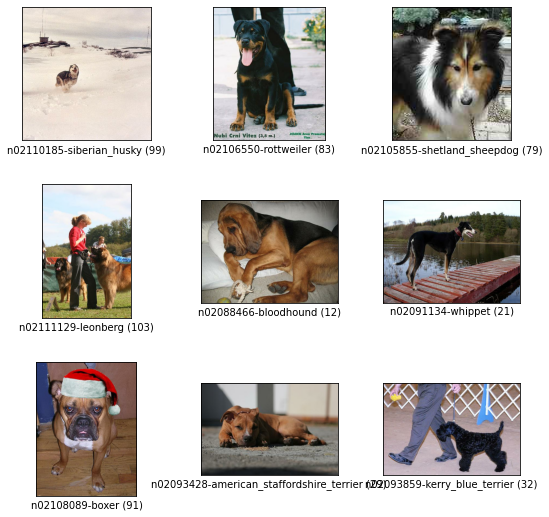

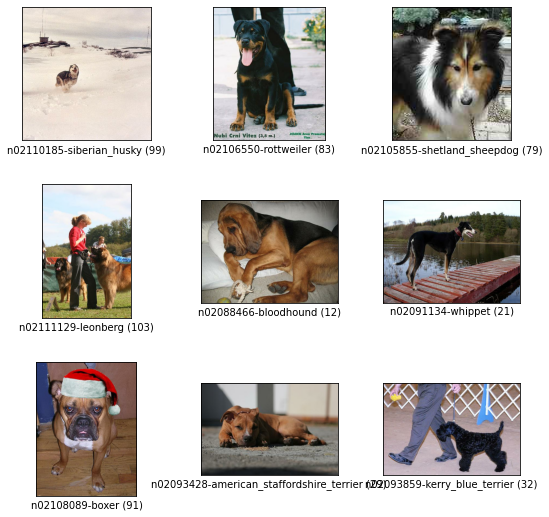

In [5]:
# tfds.show_examples() 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인
tfds.show_examples(ds_train, ds_info)

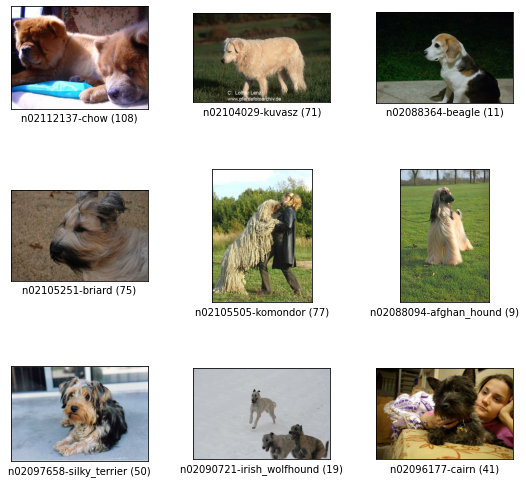

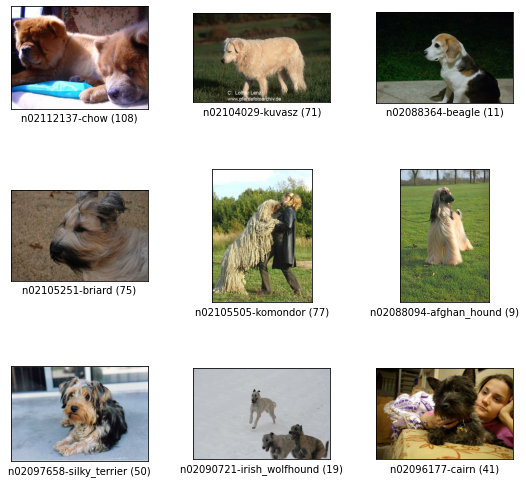

In [6]:
# 평가용 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

### (2) 물체의 위치정보
원본 이미지 위에 물체의 위치정보는 어떻게 시각화하여 표시할 수 있을까요? 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인해 봅시다.

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

먼저 image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. bbox는 무엇일까요? bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있습니다.


![img](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-3-P-2.jpg)

### 바운딩 박스를 표시하는 방법들
바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.

- **'xywh'** 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
    - (예) (x_center, y_center, width, height)
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
- **'minmax'** 는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
    - (예) (x_min, x_max, y_min, y_max)
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.
    
    
위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.

- [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

Q1. 주어진 데이터셋에서 BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요?
- 해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.

### (3) CAM을 위한 모델 만들기
이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.


### 구현해 보기
아래에서 직접 ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해 주세요. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해 보세요.

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다. 우리의 경우 ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.

- [tf.keras.applications.resnet50.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

### (4) CAM 모델 학습하기
이제 학습을 위한 과정은 이전과 비슷합니다.

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성합니다.

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [9]:
# CAM모델 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

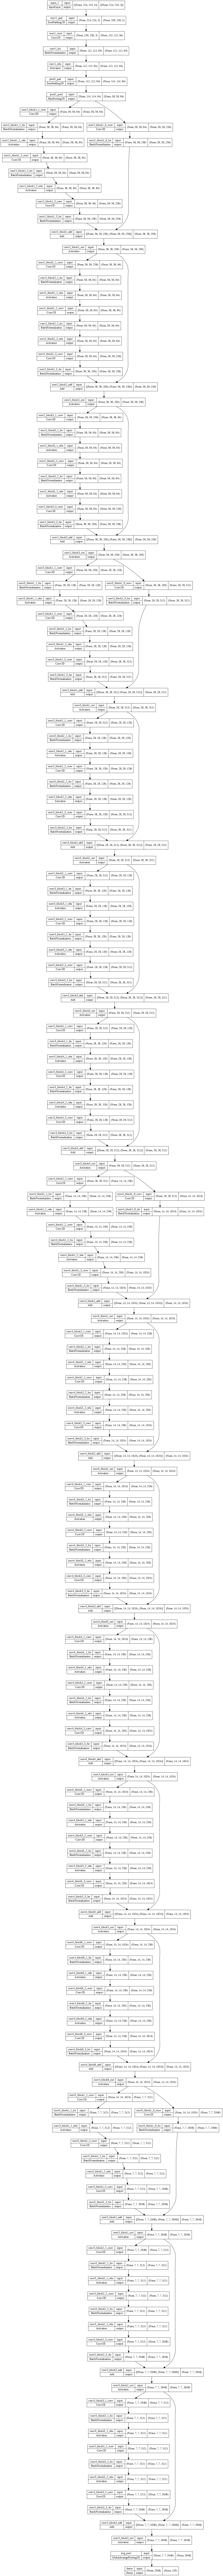

In [10]:
tf.keras.utils.plot_model(cam_model, show_shapes=True, dpi=64)

In [11]:
# CAM 모델 학습
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


이제 모델을 컴파일하고 학습시킵시다. 여기서는 맛보기로 2 Epoch 만 학습시켜 봅시다. (뒷 부분에서는 미리 준비해둔 학습된 가중치를 불러와서 모델에 적용할 예정입니다.)

In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 110s 124ms/step - loss: 2.1876 - accuracy: 0.4505 - val_loss: 3.1976 - val_accuracy: 0.2278
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.6832 - accuracy: 0.8117 - val_loss: 1.0505 - val_accuracy: 0.6876
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1802 - accuracy: 0.9682 - val_loss: 0.9518 - val_accuracy: 0.7198
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0476 - accuracy: 0.9973 - val_loss: 0.8923 - val_accuracy: 0.7355
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0203 - accuracy: 0.9998 - val_loss: 0.8879 - val_accuracy: 0.7418
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.9265 - val_accuracy: 0.7362
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9264 - val_a

학습시킨 가중치를 저장해 주겠습니다. (아래 코드의 주석을 풀면 직접 학습시킨 가중치를 저장할 수 있습니다.)

In [15]:
import os

cam_model_path = '/content/drive/MyDrive/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


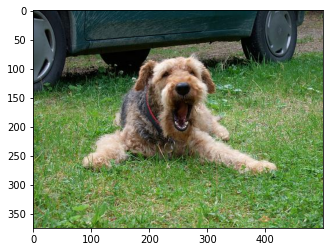

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

## 프로젝트: CAM을 만들고 평가해 보자
### 라이브러리 버전 확인하기
사용할 라이브러리 버전을 확인해봐요.

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [5]:
import os

cam_model_path = '/content/drive/MyDrive/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM 구현하기
1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

```python
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```

2) 만든 함수로 CAM 이미지를 생성합시다.

```python
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

```python
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image
```



```python
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

In [6]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

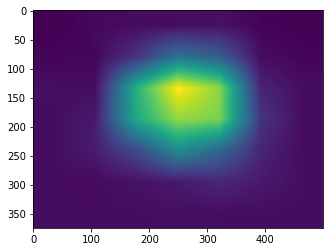

In [7]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* CAM 이미지를 원본 이미지와 합침으로써 사진에서 강아지의 특징 중 어느부분이 중요하다고 판단했는지 알아보자.
* visualize_cam_on_image() 함수: 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정함으로써 하나의 이미지에서 원본과 CAM을 겹쳐 보여준다.

In [8]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

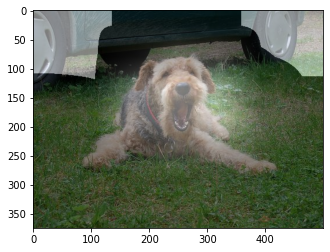

In [9]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM 구현하기
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

```python
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

* CAM 함수와 Grad-CAM의 차이점: Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

* generate_grad_cam(): 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다.

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

* 각 layer의 CAM 이미지를 뽑아서 layer를 거듭할수록 어떻게 이미지의 특징을 뽑아주는지 확인.

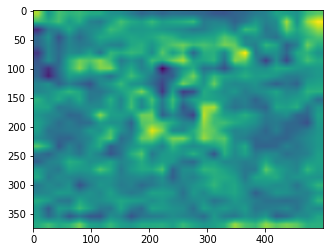

In [11]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

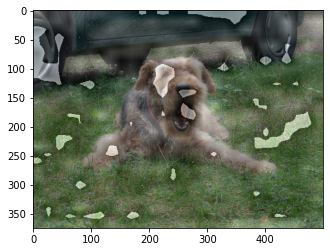

In [12]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv3 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv3, origin_image)
plt.imshow(blended_image)
plt.show()

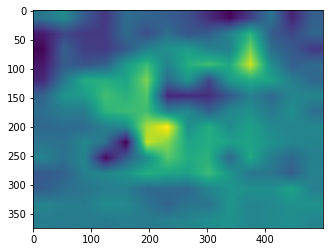

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

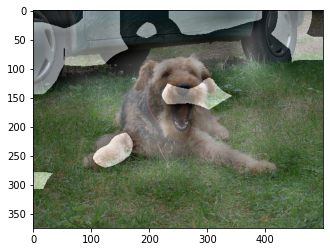

In [14]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv4 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv4, origin_image)
plt.imshow(blended_image)
plt.show()

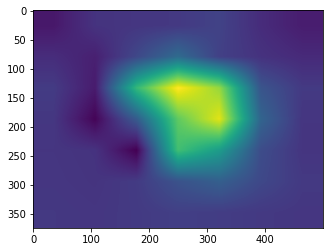

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

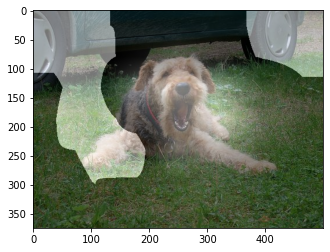

In [16]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv5 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv5, origin_image)
plt.imshow(blended_image)
plt.show()


### 바운딩 박스 구하기
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

#### Detection with CAM

In [17]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [18]:
rect = get_bbox(cam_image)
rect

array([[402, 334],
       [ 82, 263],
       [141,  -5],
       [462,  64]])

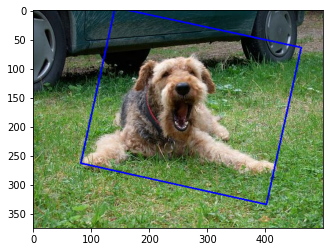

In [19]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### Detection with Grad-CAM

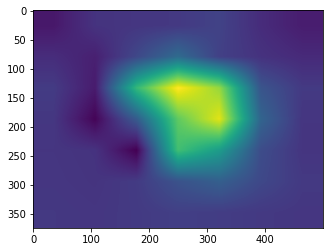

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [21]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[247, 390],
       [100,  97],
       [358, -32],
       [505, 260]])

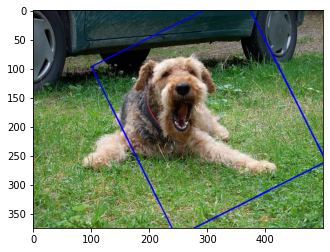

In [22]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

### IoU(IOU: Intersection Over Union) 구하기
1) **정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box)** 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

```python
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [23]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

#### Ground Truth

In [24]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

#### CAM

In [25]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.013333333333333334, 0.164, 0.8906666666666667, 0.924]

#### Grad-CAM

In [26]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[-0.08533333333333333, 0.2, 1.04, 1.01]

* CAM 추론 결과로 얻어진 bbox가 ground truth bbox가 얼마나 유사한지를 IoU를 계산해서 확인.

In [27]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [28]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5539124081120359

In [29]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.3897875980098267

#### CAM, Grad-CAM 비교

Text(0.5, 1.0, 'Grad-CAM (IoU : 0.492)')

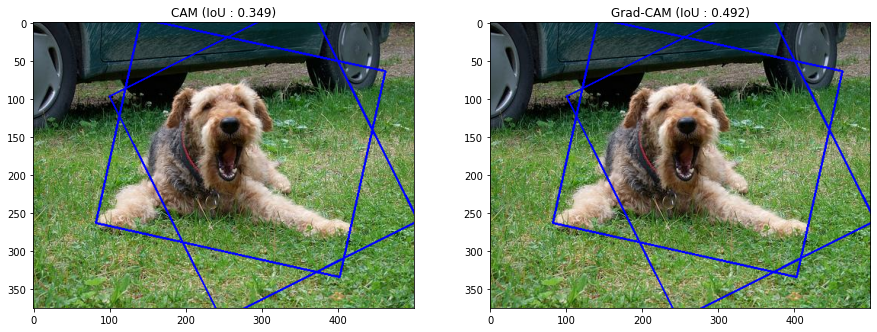

In [30]:
image = copy.deepcopy(item['image'])

image_cam = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image_grad_cam = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(image_cam)
plt.title('CAM (IoU : 0.349)')
plt.subplot(1,2,2)
plt.imshow(image_grad_cam)
plt.title('Grad-CAM (IoU : 0.492)')

## 회고


**CAM** vs **Grad-CAM** IOU 비교

* CAM: 0.5539124081120359
* Grad-CAM : 0.3897875980098267

- IoU를 비교해보면 CAM이 좀 더 높은 점수를 얻었다. Grad-CAM 보다 바운딩박스가 detection을 잘 했기 때문인 것 같다.

-  bounding bound를 비교해보면 CAM의 경우 강아지 외의 부분이 적어서 Grad-CAM보다 강아지의 부분을 잘 잡아준 것을 확인할 수 있다.

- CAM이 Grad-CAM보다 강하게 활성화된 부분이 넓다.
- Grad-CAM은 전체적으로 뿌옇다. 따라서 중요 부분이 어느 부분인지 잘 학습이 되지 않았다.

- Class activation map을 비교해보면 CAM 방식은 전반적인 면적인 반면에 Grad-CAM 방식은 특정 부분에만 집중되어 있는 것을 볼 수 있다.



- 결론적으로 Grad-CAM은 CAM에 비해 다양한 모델에 적용할 수 있다는 이점이 있으나 **CAM의 성능이 더 좋다**


